In [1]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

dir = "./data"
with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
    data = pandas.read_csv(f, header=0, skipinitialspace=True).values
    print(data.shape)


(8036, 7)


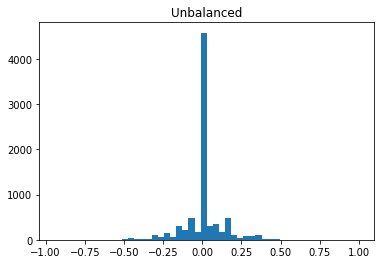

In [2]:
_ = plt.hist(data[:,3], bins=50)
plt.title('Unbalanced')
plt.show()

5923 2113
(2507, 7)


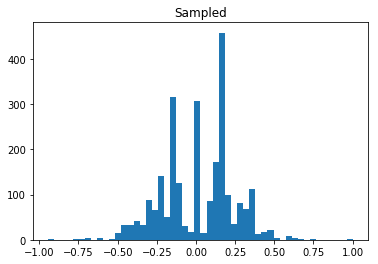

In [3]:
import random

def sampling1(data):
    limit = 0.1
    normal = np.abs(data[:,3]) < limit
    extreme = np.abs(data[:,3]) > limit
    print(len(data[normal]), len(data[extreme]))
    #nb_normal, nb_extreme = 500, 2000
    nb_normal, nb_extreme = len(data[normal])//15, len(data[extreme])
    normal_choice = np.random.choice(data[normal].shape[0], nb_normal)
    extreme_choice = np.random.choice(data[extreme].shape[0], nb_extreme)
    normal_data = data[normal][normal_choice]
    extreme_data = data[extreme][extreme_choice]
    return np.append(normal_data, extreme_data, axis=0)

def sampling2(data):
    bins, num = 100, 100
    _, b = np.histogram(data, bins)
    dist = np.digitize(data[:,3], b)
    return np.concatenate([data[dist==rng][:num] for rng in range(bins)])

sampled_data = sampling1(data)
print(sampled_data.shape)
_ = plt.hist(sampled_data[:,3], bins=50)
plt.title('Sampled')
plt.show()

(7521,) (7521,)


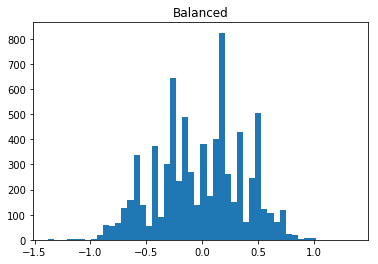

In [4]:
from sklearn.utils import shuffle

c, l, r, st, _, _, _ = np.split(sampled_data, 7, axis=1)
adj = 0.2
balanced_feats = np.append(c, l)
balanced_feats = np.append(balanced_feats, r)
balanced_labels = np.append(st, st + 0.15*random.uniform(2, 3.5))
balanced_labels = np.append(balanced_labels, st - 0.15*random.uniform(2, 3.5))
#balanced_feats, balanced_labels = shuffle(balanced_feats, balanced_labels)
print(balanced_feats.shape, balanced_labels.shape)

_ = plt.hist(balanced_labels, bins=50)
plt.title('Balanced')
plt.show()

In [5]:
span = len(c)
print(balanced_labels[0], balanced_labels[span*1], balanced_labels[span*2])
print(balanced_feats[0], balanced_feats[span*1], balanced_feats[span*2])

print(balanced_labels[span-1], balanced_labels[2*span-1], balanced_labels[3*span-1])
print(balanced_feats[span-1], balanced_feats[2*span-1], balanced_feats[3*span-1])


0.0 0.34283505839716405 -0.4341176917855981
IMG/center_2016_12_01_13_33_59_244.jpg IMG/left_2016_12_01_13_33_59_244.jpg IMG/right_2016_12_01_13_33_59_244.jpg
0.1287396 0.47157465839716406 -0.3053780917855981
IMG/center_2016_12_01_13_35_00_638.jpg IMG/left_2016_12_01_13_35_00_638.jpg IMG/right_2016_12_01_13_35_00_638.jpg


[5009 3471 5132]
[0.4811432583971641 0.06470765839716403 -0.3819263217855981]
(7521, 66, 200, 3)


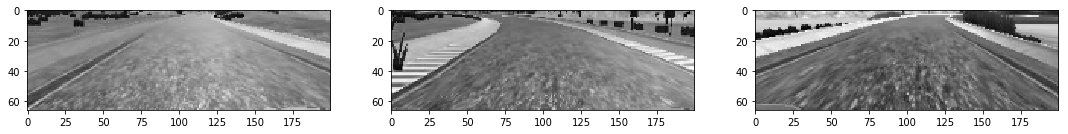

In [6]:
import cv2
import matplotlib.image as mpimg

def cropImage(image):
    image = image[60:140,:,:]
    return image

def resizeImage(image):
    image = cv2.resize(image, (200, 66))
    return image

def rgb2yuv(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    return image

def read_image(f):
    #image = cv2.cvtColor(cv2.imread(os.path.join(dir, f)), cv2.COLOR_BGR2YUV)[:,:,0:1]
    image = mpimg.imread(os.path.join(dir, f));
    image = cropImage(image)
    image = resizeImage(image)
    image = rgb2yuv(image)    
    return image 

image_features = np.array([read_image(f) for f in balanced_feats])
image_labels = balanced_labels
samples = np.random.choice(image_features.shape[0], 3)
print(samples)
f = plt.figure(figsize=(25,14))
for i in range(len(samples)): 
    s = f.add_subplot(2,4,i+1)
    s.imshow(image_features[samples[i]][:,:,0], cmap='gray')
print(image_labels[samples])
print(image_features.shape)
plt.show()

(11039, 66, 200, 3) (11039,)


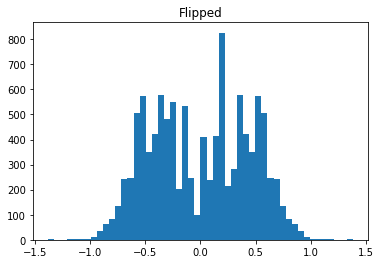

In [7]:
def flipVertical(image):
    image = cv2.flip(image, 1)
    return image

flip_limit = 0.3
flip = np.logical_or(image_labels < -flip_limit, image_labels > flip_limit)
flipped_features = np.append(image_features, [flipVertical(f) for f in image_features[flip]], axis=0)
flipped_labels = np.append(image_labels, -image_labels[flip], axis=0)
print(flipped_features.shape, flipped_labels.shape)

_ = plt.hist(flipped_labels, bins=50)
plt.title('Flipped')
plt.show()

0.46363820000000006 -0.46363820000000006


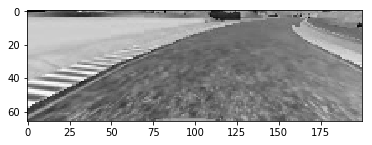

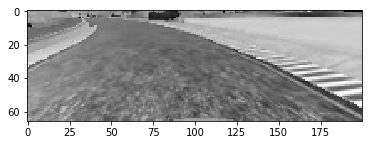

In [8]:
print(image_labels[flip][0], flipped_labels[len(image_labels)])
plt.imshow(image_features[flip][0][:,:,0], cmap='gray')
plt.figure()
plt.imshow(flipped_features[len(image_features)][:,:,0], cmap='gray')
plt.show()

In [9]:
def translate(img, angle):
    TRANS_X_RANGE = 100  # Number of translation pixels up to in the X direction for augmented data (-RANGE/2, RANGE/2)
    TRANS_Y_RANGE = 40  # Number of translation pixels up to in the Y direction for augmented data (-RANGE/2, RANGE/2)
    TRANS_ANGLE = .3  # Maximum angle change when translating in the X direction
    x_translation = (TRANS_X_RANGE * np.random.uniform()) - (TRANS_X_RANGE / 2)
    new_angle = angle + ((x_translation / TRANS_X_RANGE) * 2) * TRANS_ANGLE
    y_translation = (TRANS_Y_RANGE * np.random.uniform()) - (TRANS_Y_RANGE / 2)

    # Form the translation matrix
    translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])

    # Translate the image
    im = cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))
    return im, new_angle

# trans_limit = 0.5
# trans = np.logical_or(flipped_labels < -trans_limit, flipped_labels > trans_limit)

# translated_labels = []
# translated_features = []
# for f, a in zip(flipped_features[trans], flipped_labels[trans]):
#     tf, ta = translate(f, a)
#     translated_features.append(tf)
#     translated_labels.append(ta)
    
# translated_labels = np.array(translated_labels)
# translated_features = np.array(translated_features).reshape(-1, 160,320,1)

# print(translated_features.shape, translated_labels.shape)  


# features = np.append(flipped_features, translated_features, axis=0)
# labels = np.append(flipped_labels, translated_labels, axis=0)

# print(flipped_features[trans].shape, flipped_labels[trans].shape)
# print(features.shape, labels.shape)


In [10]:

# _ = plt.hist(labels, bins=100)
# plt.title('Translated')
# plt.show()


Using TensorFlow backend.


(11039, 66, 200, 3) (11039,)
(None, 66, 200, 3)
(None, 31, 98, 24)
(None, 14, 47, 36)
(None, 5, 22, 48)
(None, 3, 20, 64)
(None, 1, 18, 64)
(None, 1152)
(None, 100)
(None, 50)
(None, 10)
(None, 1)
Epoch 1/5
142s - loss: 0.1547 - val_loss: 0.0975
Epoch 2/5
150s - loss: 0.1164 - val_loss: 0.0806
Epoch 3/5
145s - loss: 0.1084 - val_loss: 0.0761
Epoch 4/5
145s - loss: 0.1058 - val_loss: 0.0731
Epoch 5/5
144s - loss: 0.1029 - val_loss: 0.0728


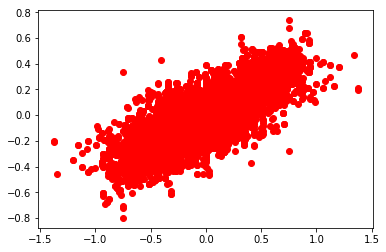

[-0.79893124] [ 0.73752636]


In [11]:
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

X_train, y_train = flipped_features, flipped_labels
print(X_train.shape, y_train.shape)

def my_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=X_train.shape[1:]))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c1'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    
    model.add(Convolution2D(128, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='d1'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='linear', name='d2'))
    model.add(Dense(16, activation='relu', name='d3'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear', name='out'))
    
    return model

def stolen_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(X_train.shape[1], X_train.shape[2], 3), name='Normalization'))
    print(model.output_shape)
    model.add(Convolution2D(24, 5, 5, activation='relu', border_mode='valid', subsample=(2,2), name='Conv1'))
    model.add(Dropout(0.2))
    print(model.output_shape)
    model.add(Convolution2D(36, 5, 5, activation='relu', border_mode='valid', subsample=(2,2), name='Conv2'))
    model.add(Dropout(0.2))
    print(model.output_shape)
    model.add(Convolution2D(48, 5, 5, activation='relu', border_mode='valid', subsample=(2,2), name='Conv3'))
    model.add(Dropout(0.2))
    print(model.output_shape)
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='valid', subsample=(1,1), name='Conv4'))
    model.add(Dropout(0.2))
    print(model.output_shape)
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='valid', subsample=(1,1), name='Conv5'))
    model.add(Dropout(0.2))
    print(model.output_shape)
    model.add(Flatten())
    print(model.output_shape)
    #model.add(Dense(1164, activation='relu', name='FC1'))
    model.add(Dense(100, activation='relu', name='FC2'))
    model.add(Dropout(0.5))
    print(model.output_shape)
    model.add(Dense(50, activation='relu', name='FC3'))
    #model.add(Dropout(0.5))
    print(model.output_shape)
    model.add(Dense(10, activation='relu', name='FC4'))
    model.add(Dropout(0.5))
    print(model.output_shape)
    model.add(Dense(1, name='final_output'))
    print(model.output_shape)
    
    return model

def stolen_training(X_train, y_train):
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.01, random_state = 0)
    model = stolen_model()
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(optimizer=adam, loss='mse')
    nbEpoch = 5
    datagen = ImageDataGenerator()
    datagen.fit(X_train)
    history = model.fit_generator(
        datagen.flow(X_train, y_train, batch_size=32),
        samples_per_epoch=X_train.shape[0],
        nb_epoch=nbEpoch,
        validation_data=(X_validation, y_validation),
        verbose=2)
    y_pred = model.predict(X_train)
    model.save("model.stolen.h5")
    plt.plot(y_train, y_pred, 'ro')
    plt.show()
    print(np.min(y_pred, axis=0), np.max(y_pred, axis=0))
    
    

def nvidia_model():
    model = Sequential()
    #model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 3)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66, 200, 3)))    
    model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='relu', name='c1', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu', name='c2', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu', name='c3', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', name='c4'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', name='c5'))
    model.add(Dropout(0.2))
    model.add(Flatten())
#     model.add(Dense(1164, name='d1'))
#     model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', name='d2'))
    model.add(Dropout(0.5))    
    model.add(Dense(50, activation='relu', name='d3'))
    model.add(Dense(10, activation='relu', name='d4'))
    model.add(Dropout(0.5))        
    model.add(Dense(1, name='out'))

    return model

#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.01, random_state = 0)

# model = my_model()
# adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
# model.compile(optimizer=adam, loss='mse')

# history = model.fit(X_train, y_train, batch_size=32, nb_epoch=5, verbose=2, validation_split=0.05)

stolen_training(X_train, y_train)


# y_pred = model.predict(X_train)
# model.save("model.new.h5")

# plt.plot(y_train, y_pred, 'ro')
# plt.show()
# print(np.min(y_pred, axis=0), np.max(y_pred, axis=0))
